# 2. Clustering Based on Evidence Quality and SQL Length


In [33]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
file_path = 'processed_dataset.csv'
data = pd.read_csv(file_path)


In [35]:
if all(col in data.columns for col in ['sql_length', 'evidence']):
    data['sql_length'].fillna(data['sql_length'].mean(), inplace=True)
    data['evidence'].fillna('', inplace=True)

    data['sql_length_norm'] = data['sql_length'] / data['sql_length'].max()
    data['evidence_length'] = data['evidence'].str.len()
    data['evidence_norm'] = data['evidence_length'] / data['evidence_length'].max()
else:
    raise ValueError("The dataset does not contain the required columns for clustering.")


/var/folders/pr/ydlx3rfj3sq65q5pkjgnkqgh0000gn/T/ipykernel_54861/2763534830.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['sql_length'].fillna(data['sql_length'].mean(), inplace=True)
/var/folders/pr/ydlx3rfj3sq65q5pkjgnkqgh0000gn/T/ipykernel_54861/2763534830.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are s

In [36]:
print(data[['sql_length_norm', 'evidence_norm']].isna().sum())

sql_length_norm    0
evidence_norm      0
dtype: int64


In [37]:
features = ['sql_length_norm', 'evidence_norm']
X = data[features]

In [38]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [39]:
clustering_algorithms = {
    "K-Means": KMeans(n_clusters=3, random_state=42),
    "DBSCAN": DBSCAN(eps=0.5, min_samples=5),
    "Gaussian Mixture": GaussianMixture(n_components=3, random_state=42)
}

results = {}

Running K-Means...


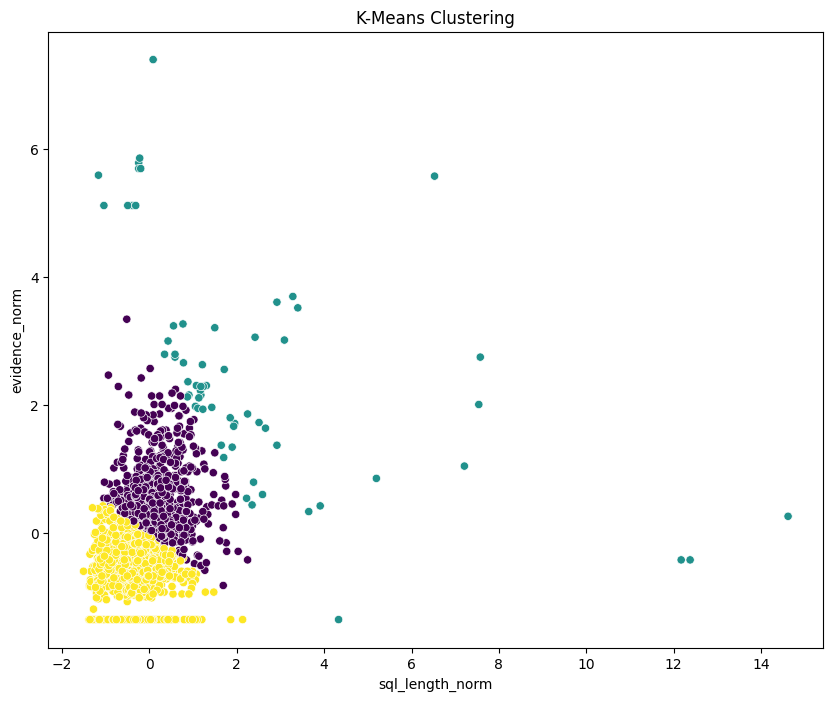

Running DBSCAN...


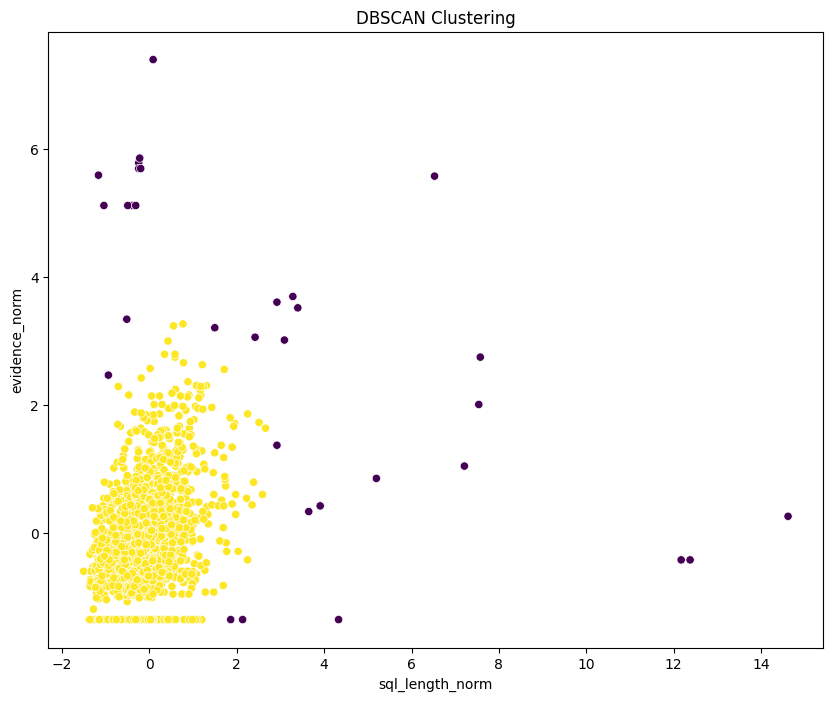

Running Gaussian Mixture...


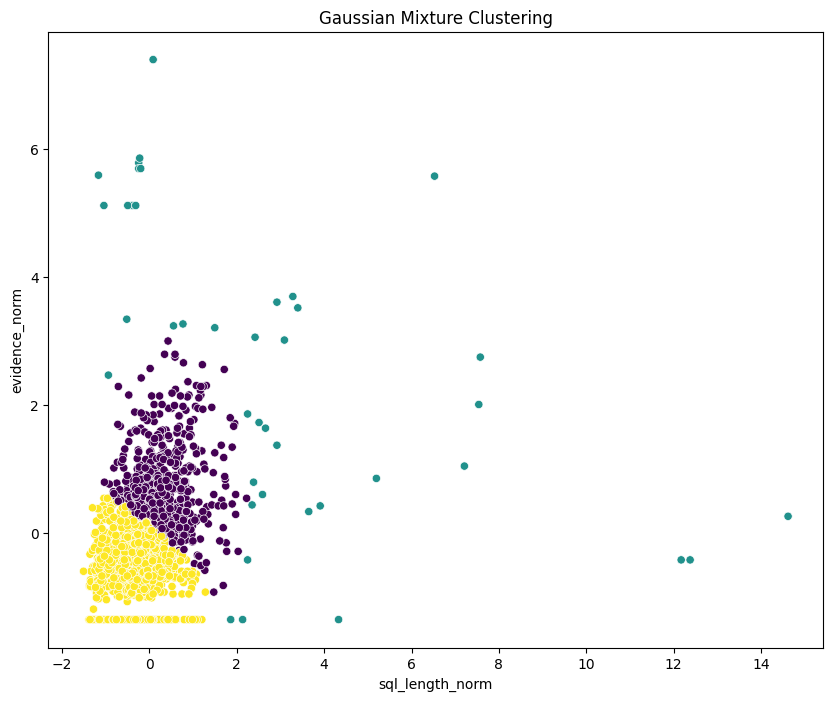

In [40]:
for name, algorithm in clustering_algorithms.items():
    print(f"Running {name}...")
    
    if name == "Gaussian Mixture":
        labels = algorithm.fit_predict(X_scaled)
    else:
        algorithm.fit(X_scaled)
        labels = algorithm.labels_
    
    if len(set(labels)) > 1:
        silhouette = silhouette_score(X_scaled, labels)
        dbi = davies_bouldin_score(X_scaled, labels)
        chi = calinski_harabasz_score(X_scaled, labels)
    else:
        silhouette = -1
        dbi = float('inf')
        chi = -1

    results[name] = {
        "Labels": labels,
        "Silhouette Score": silhouette,
        "Davies-Bouldin Index": dbi,
        "Calinski-Harabasz Index": chi
    }
    
    data[f"{name}_cluster"] = labels

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=labels, palette='viridis', legend=None)
    plt.title(f"{name} Clustering")
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.show()

/var/folders/pr/ydlx3rfj3sq65q5pkjgnkqgh0000gn/T/ipykernel_54861/4081551092.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="viridis")


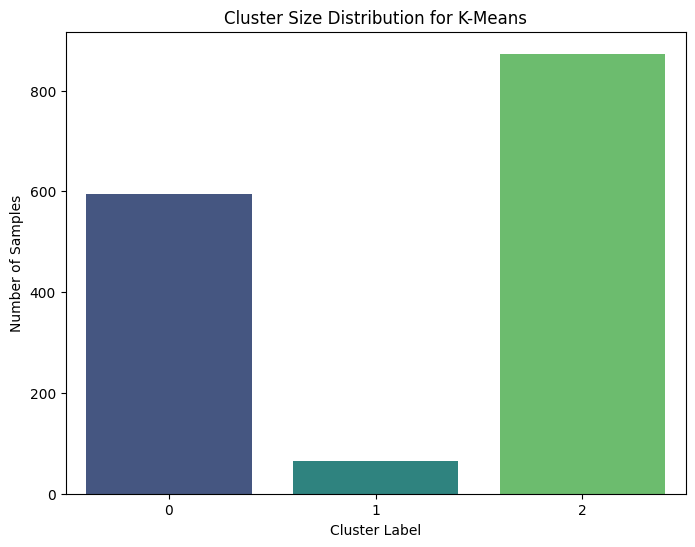

/var/folders/pr/ydlx3rfj3sq65q5pkjgnkqgh0000gn/T/ipykernel_54861/4081551092.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="viridis")


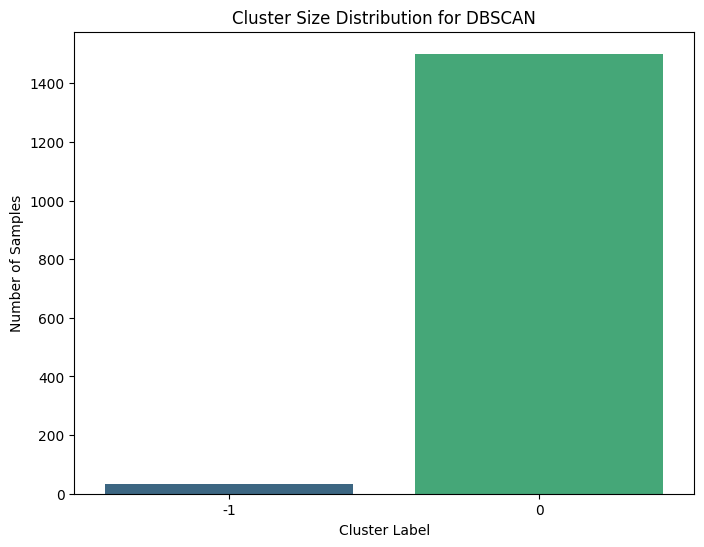

/var/folders/pr/ydlx3rfj3sq65q5pkjgnkqgh0000gn/T/ipykernel_54861/4081551092.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="viridis")


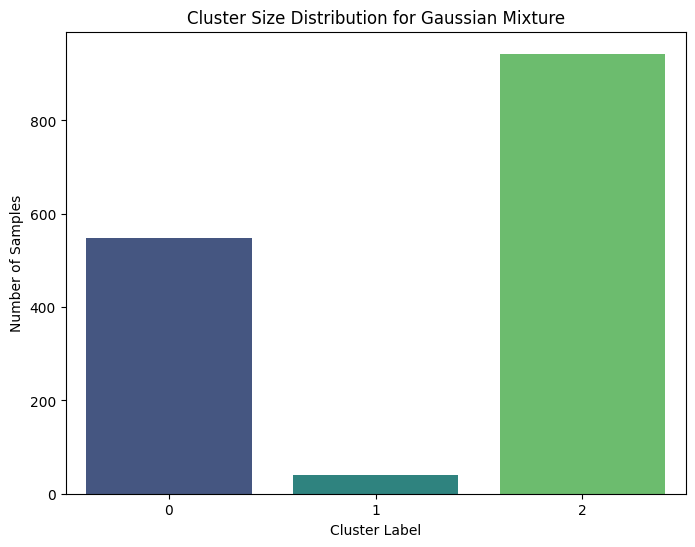

In [41]:
for name, result in results.items():
    labels = result["Labels"]
    unique, counts = np.unique(labels, return_counts=True)
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x=unique, y=counts, palette="viridis")
    plt.title(f"Cluster Size Distribution for {name}")
    plt.xlabel("Cluster Label")
    plt.ylabel("Number of Samples")
    plt.show()

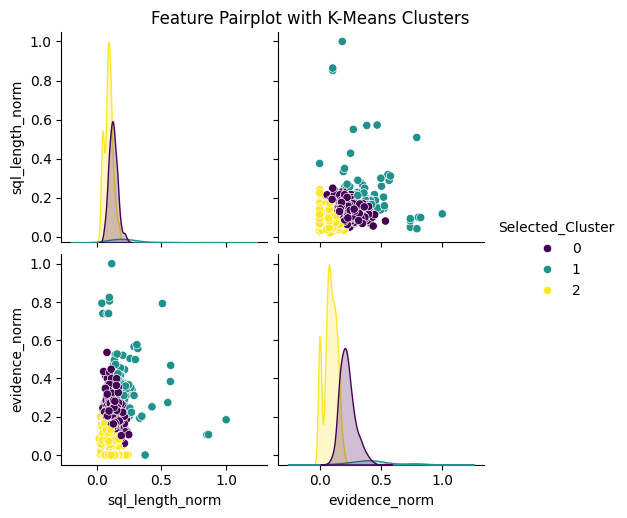

In [42]:
data['Selected_Cluster'] = results["K-Means"]["Labels"]

sns.pairplot(data, vars=features, hue="Selected_Cluster", palette="viridis", diag_kind="kde")
plt.suptitle("Feature Pairplot with K-Means Clusters", y=1.02)
plt.show()

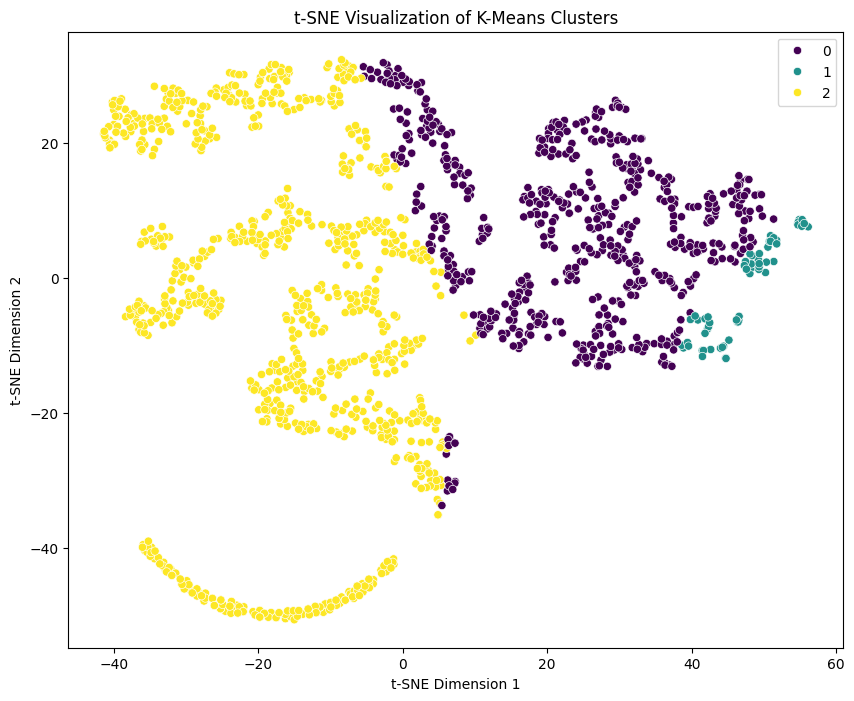

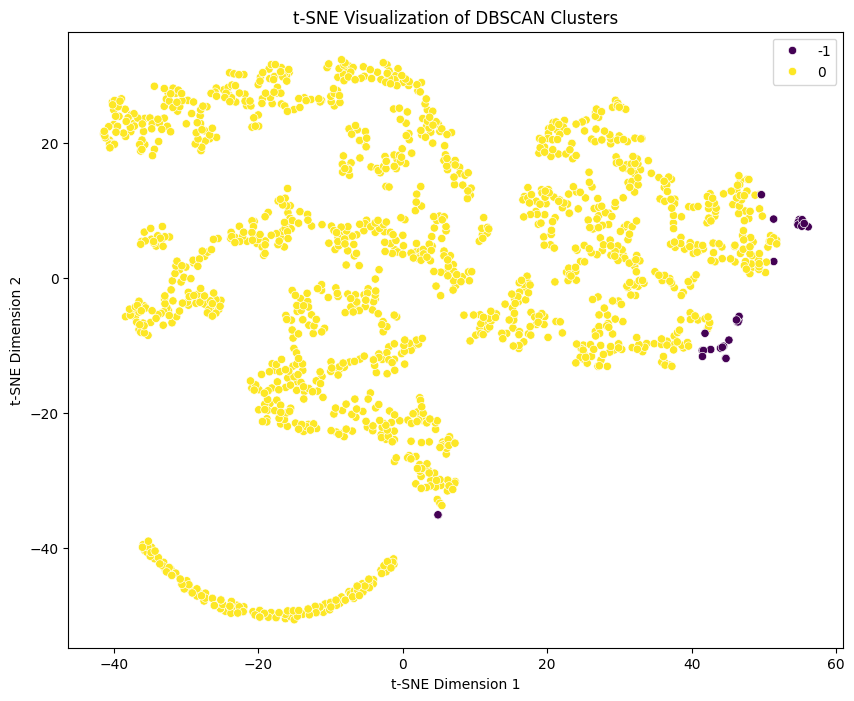

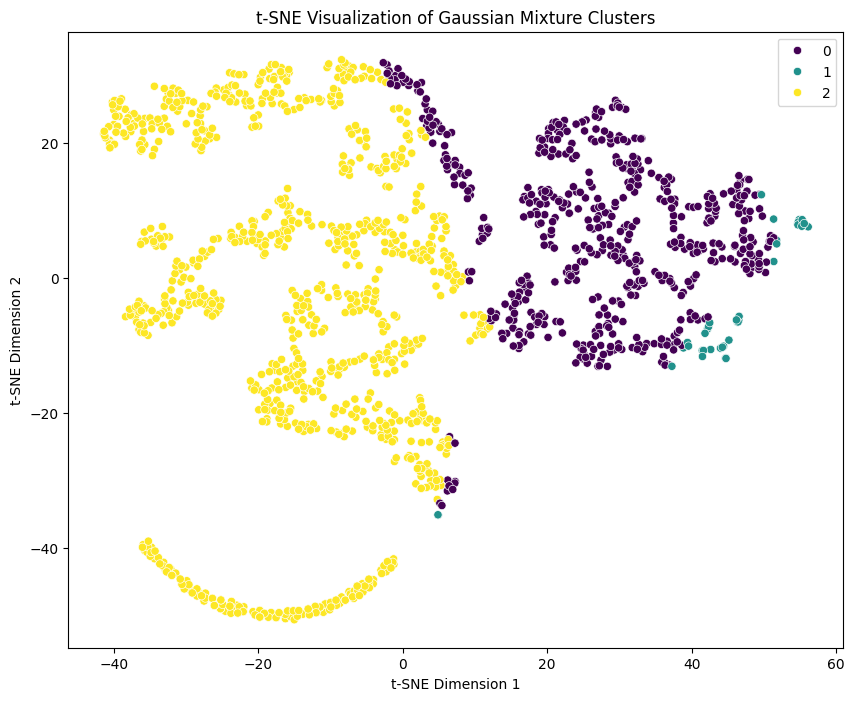

In [43]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_scaled)

for name, result in results.items():
    labels = result["Labels"]
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette="viridis", legend="full")
    plt.title(f"t-SNE Visualization of {name} Clusters")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

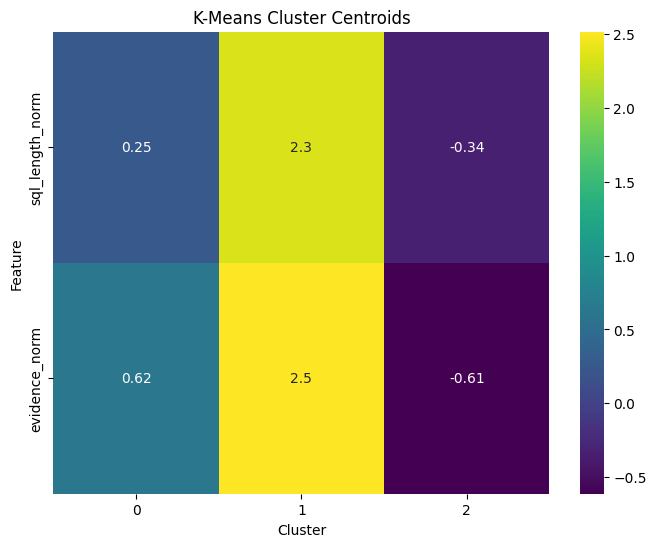

In [44]:
if "K-Means" in clustering_algorithms:
    kmeans_centroids = clustering_algorithms["K-Means"].cluster_centers_
    centroids_df = pd.DataFrame(kmeans_centroids, columns=features)

    plt.figure(figsize=(8, 6))
    sns.heatmap(centroids_df.T, annot=True, cmap="viridis", cbar=True)
    plt.title("K-Means Cluster Centroids")
    plt.xlabel("Cluster")
    plt.ylabel("Feature")
    plt.show()

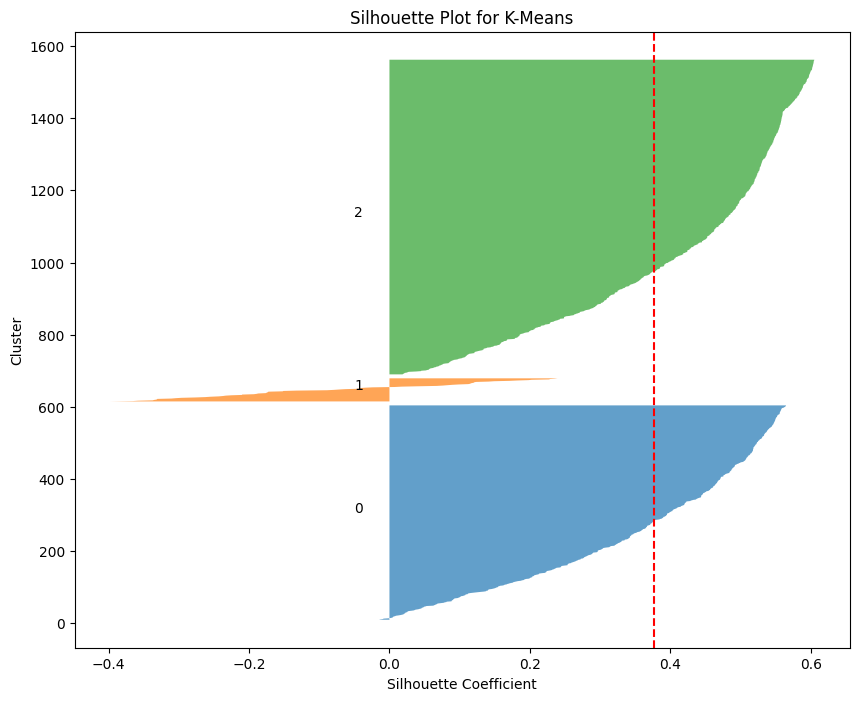

In [45]:
from sklearn.metrics import silhouette_samples

# Silhouette plot for a selected algorithm (e.g., K-Means)
selected_model = "K-Means"
labels = results[selected_model]["Labels"]
silhouette_vals = silhouette_samples(X_scaled, labels)

plt.figure(figsize=(10, 8))
y_lower = 10
for i in range(len(np.unique(labels))):
    ith_cluster_silhouette_vals = silhouette_vals[labels == i]
    ith_cluster_silhouette_vals.sort()
    size_cluster_i = ith_cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_vals, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # 10 for the 0 samples

plt.title(f"Silhouette Plot for {selected_model}")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Cluster")
plt.axvline(x=np.mean(silhouette_vals), color="red", linestyle="--")
plt.show()

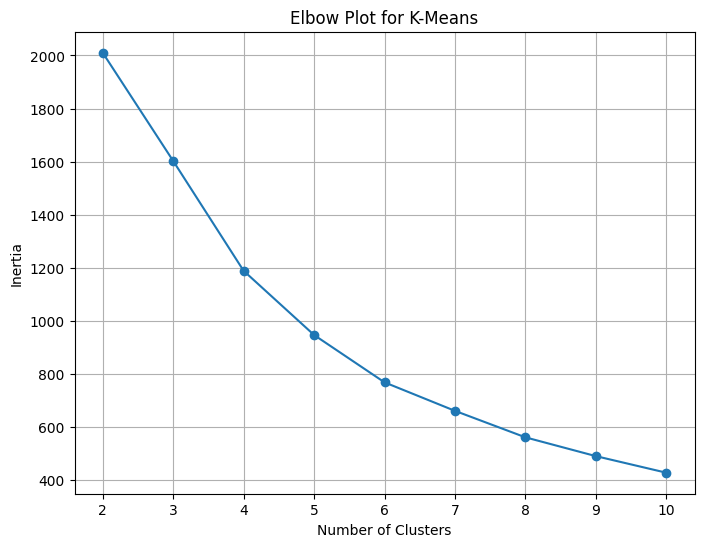

In [46]:
inertia = []
k_range = range(2, 11)  # Test for 2 to 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Plot for K-Means")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid()
plt.show()